# Полный расчет

In [6]:
#Ввод входные параметров модели
#ВНИМАНИЕ: степень задается через **, а не ^

k_Frac = 2*10**(-13) #Проницаемость в трещине
k_SRV = 2*10**(-18) #Проницаемость в зоне SRV
k_Matrix = 2*10**(-19) #Проницаемость в матрице
#kNonLinear_SRV = 0 #Коэффициент при нелинейной части проницаемости
m = 0.05 #Пористость
C = 2.5*10**(-9) #Общая сжимаемость
mu = 0.5*10**(-3) #Вязкость жидкости
H = 35 #высота трещины
Pstart = 230*100000 #Начальное давление в пласте
Pwell = 50*100000 #Давление в скважине
D_SRV = k_SRV/(mu*m*C) #Расчет коэффициенты пьезопроводности в зоне SRV
D_Matrix = k_Matrix/(mu*m*C) #Расчет коэффициенты пьезопроводности в матрице
D_Frac = k_Frac/(mu*m*C) #Расчет коэффициенты пьезопроводности в трещине
#DNonLinear_SRV = kNonLinear_SRV/(mu*m*C)
#Шаг по времени
#Кол-во шагов по времени

In [2]:
#Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fipy as fp #библиотека солвер
from fipy.tools import numerix
import matplotlib.pyplot as plt #Для визуализации
from fipy import CellVariable, Gmsh2D, TransientTerm, DiffusionTerm, Viewer
from fipy.tools import numerix
from fipy.viewers.matplotlibViewer.matplotlib2DGridContourViewer import Matplotlib2DGridContourViewer as Viewer

In [9]:
#----------------------------------------------------------------
#----------------------Блок задания сеток и геометрии------------
#----------------------------------------------------------------
#Параметры сеток
#Трещина
nx_Frac = 7 #Разрядность по координате x
ny_Frac = 800 #Разрядность по координате y
dx_Frac = 0.001 #Ширина ячейки по координате x
dy_Frac = 1 #Ширина ячейки по координате y
#Зона SRV (размер nx_SRV*dx_SRV х ny_SRV*dy_SRV)
nx_SRV = 10
ny_SRV = 800
dx_SRV = 0.2
dy_SRV = 1
#Боковая часть зоны незатронутой ГРП
nx_MatrixLateral = 15
ny_MatrixLateral = 800
dx_MatrixLateral = 0.2
dy_MatrixLateral = 1

#Инициализация сеток
#Сетка в левой боковой части зоны незатронутой ГРП
MatrixLateralLeftMesh = fp.Grid2D(dx=dx_MatrixLateral, 
                                  dy=dy_MatrixLateral, 
                                  nx=nx_MatrixLateral, 
                                  ny=ny_MatrixLateral)        
#Сетка на левом крыле SRV
SrvLeftMesh =(fp.Grid2D(dx=dx_SRV, 
          dy=dy_SRV, 
          nx=nx_SRV, 
          ny=ny_SRV)+((dx_MatrixLateral*nx_MatrixLateral,),(0,)))
#Сетка на внутри трещины
FracMesh = (((dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV,), (0,)) 
+ fp.Grid2D(dx=dx_Frac, 
            dy=dy_Frac, 
            nx=nx_Frac, 
            ny=ny_Frac))
#Сетка на правом крыле SRV
SrvRightMesh =(((dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac,), (0,))
    +fp.Grid2D(dx=dx_SRV, 
          dy=dy_SRV, 
          nx=nx_SRV, 
          ny=ny_SRV))
#Сетка в правой боковой части зоны незатронутой ГРП
MatrixLateralRightMesh = (((dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac,), (0,)) 
+ fp.Grid2D(dx=dx_MatrixLateral, 
            dy=dy_MatrixLateral, 
            nx=nx_MatrixLateral, 
            ny=ny_MatrixLateral))
#Склейка сеток 
mesh = (MatrixLateralLeftMesh + SrvLeftMesh + FracMesh+SrvRightMesh+MatrixLateralRightMesh)


#----------------------------------------------------------------
#----------------------Блок задания начально-краевых условий-----
#----------------------------------------------------------------
#Задание переменной решения
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = Pstart) 

#Координаты начала и конца трещины по оси x
FracXcoordStart = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV
FracXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac
#Координаты начала и конца трещины по оси y
FracYcoordStart = 200
FracYcoordFinish = 600
#Координаты середины трещины по оси y
FracYcoordMedium = 400

X, Y = mesh.faceCenters #Массивы координат граней ячеек
x, y = mesh.cellCenters #Массивы координат центров ячеек
#Массивы определяющие является ли грань/ячейка скважиной
Fracfaces = (X >= FracXcoordStart) & (X <= FracXcoordFinish) & (Y >= FracYcoordMedium-1) & (Y < FracYcoordMedium+1)
FracCell = (x > FracXcoordStart) & (x < FracXcoordFinish) & (y > FracYcoordMedium-1) & (y < FracYcoordMedium+1)

#Задание начального и краевого давления в "скважине"
phi.setValue(Pwell, where=FracCell) 
phi.constrain(Pwell, Fracfaces)

#----------------------------------------------------------------
#------------------Блок задания коэфициента пьезопроводности-----
#----------------------------------------------------------------
#Задание переменной коэффициента пьезопроводности (всюду = D_SRV)
D = fp.FaceVariable(mesh=mesh, value=D_SRV)
#Изменение коэффициента пьезопроводности в зоне трещины
mask = ((X >= FracXcoordStart) & (X <= FracXcoordFinish)) & (Y >= FracYcoordStart) & (Y <= FracYcoordFinish)
D.setValue(D_Frac, where=mask)

#Изменение коэффициента пьезопроводности в зоне матрицы
#Координаты границ матриц по осям x и y
MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D.setValue(D_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D.setValue(D_Matrix, where=mask)

In [257]:
#Задание нелинейной части коэффициента пьезопроводности и уравнения
D_nonlinear_SRV = 1
D_nonlinear_Matrix = 0
D_nonlinear_Frac = 0

D_nonlinear = fp.FaceVariable(mesh=mesh, value=D_nonlinear_SRV)
mask = ((X >= FracXcoordStart) & (X <= FracXcoordFinish)) & (Y >= FracYcoordStart) & (Y <= FracYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Frac, where=mask)


MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)

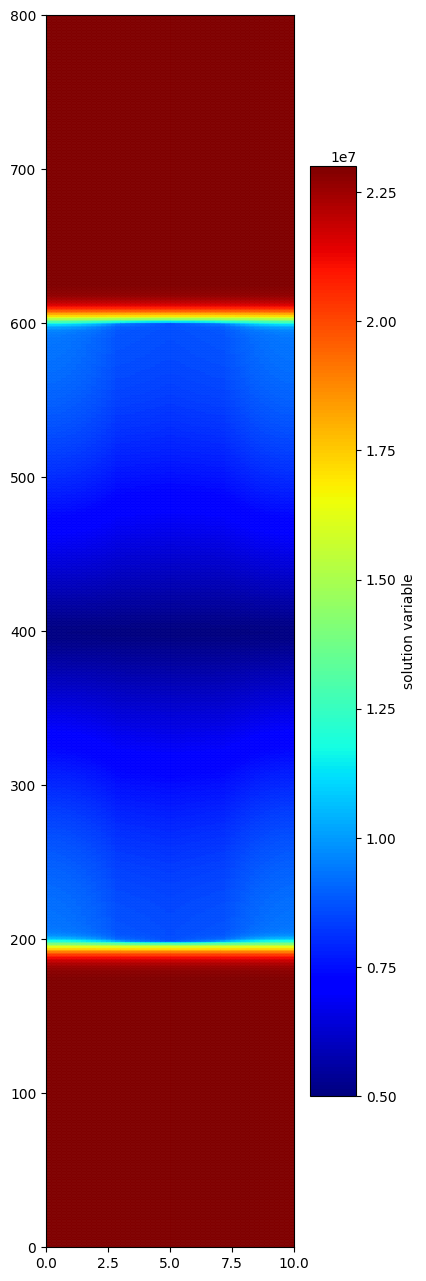

Время t = 240.0
Дебит, м^3/сут 0.4592132092800011
3.2000000000000005e-05


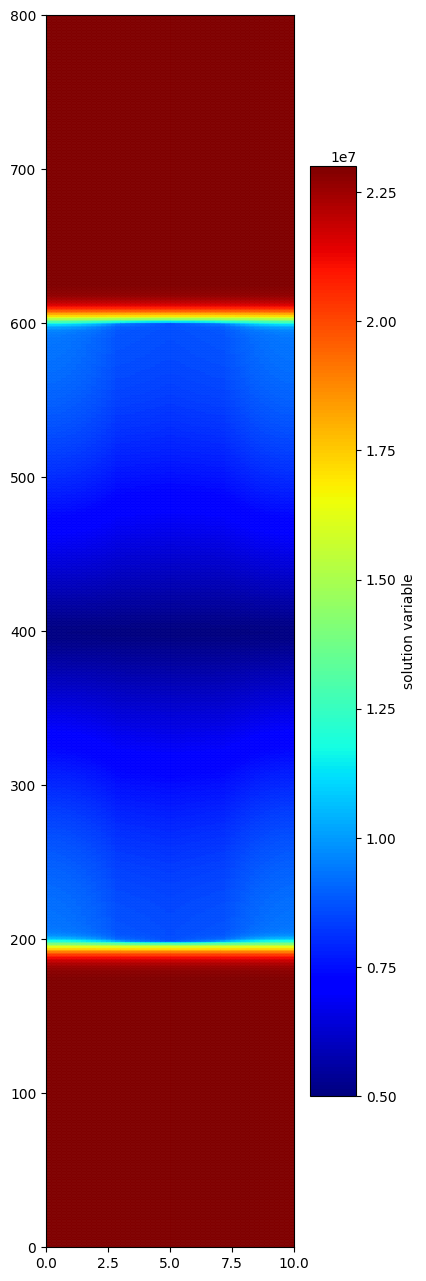

In [10]:
#Задание уравнения
D_nonlinear = 0
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=D*(1-D_nonlinear*phi.arithmeticFaceValue/Pstart))

Q = [] #Массив дебитов
timeStepDuration = 10*24*3600 #Шаг по временной переменной
steps = 18 #Кол-во шагов по временной переменной
viewer = fp.Viewer(vars=phi) #Отображатель переменной
solver = fp.GeneralSolver(precon='lu') #Решатель
from builtins import range
for step in range(steps):
    eq.solve(var=phi, dt=timeStepDuration)
    viewer.plot()
    print('Время t = '+str(timeStepDuration/3600))
    
    #----------------------------------------------------------------
    #------------------Блок расчета дебитов--------------------------
    #----------------------------------------------------------------  
    #Шаг 1 расчет градиентов давления
    ListGradSolution_X = [] #с 0 счет идет
    ListGradSolution_Y = [] #с 0 счет идет
    ListSolution = []
    a = mesh
    xa, ya = a.cellCenters
    k = 0
    for j in range(0, len(np.unique(xa))):
        for i in range(0, len(np.unique(ya))):
            ListGradSolution_X.append([xa[k], ya[k], phi.grad.value[0][k]])
            ListGradSolution_Y.append([xa[k], ya[k], phi.grad.value[1][k]])
            k = k + 1
    
    #Шаг 2 расчет градиентов давления вокруг скважины
    #Расчет градиентов в ячейках на левой грани скважины
    y_temp = [399.5, 400.5]
    sum_grad_x = 0
    for score in ListGradSolution_X:
        for y in y_temp:
            if score[0]==4.9 and score[1] == y:
                #домножаем на 2 т.к. градиент на границе скважины неправильно считается
                sum_grad_x = sum_grad_x + 2*score[2]               
    #Расчет градиентов в ячейках на нижней грани скважины
    x_temp = [5.000500000000001, 5.0015, 5.0024999999999995, 5.0035, 5.0045, 5.0055, 5.0065]
    sum_grad_y = 0
    for score in ListGradSolution_Y:
        for x in x_temp:
            if score[0]==x and score[1] == 398.5:
                #домножаем на 2 т.к. градиент на границе скважины неправильно считается
                sum_grad_y = sum_grad_y + 2*score[2]
  
    #Шаг 3 расчет дебитов вокруг скважины  
    Sx = H*dx_Frac #Площади граней ячеек вокруг скважины по x
    Sy = H*dy_SRV #Площади граней ячеек вокруг скважины по y    
    Qx = -k_SRV*sum_grad_x*Sy/mu #Вычисление потока слева от скважины    
    Qy = -k_Frac*sum_grad_y*Sx/mu #Вычисление потока справа от скважины

    #Домножаем на 2 так как сторон 4
    Q.append([timeStepDuration*step/(24*3600), 2*(Qx+Qy)*24*3600])
    print('Дебит, м^3/сут '+str((Qx+Qy)*24*3600))
    
    a = D*(1-1*D_nonlinear*phi.arithmeticFaceValue/Pstart)
    print(min(a[a>3.3*10**(-6)]))

,Время (сут),Дебит (м^3/сут)
0,0.0,11.142200
1,10.0,6.917898
2,20.0,5.390519
3,30.0,4.471204
4,40.0,3.814486
5,50.0,3.309871
6,60.0,2.905733
7,70.0,2.572594
8,80.0,2.291950
9,90.0,2.051508


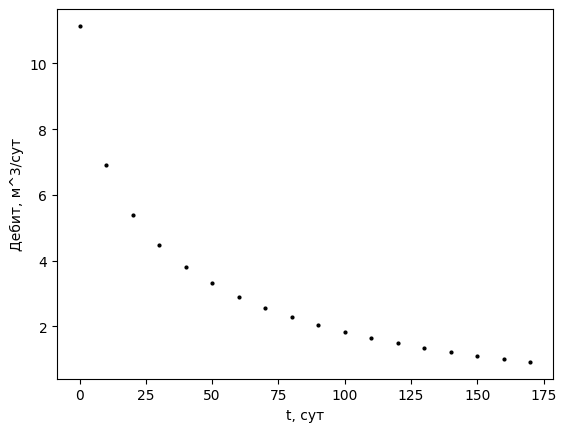

In [15]:
#----------------------------------------------------------------
#------------------Блок визуализации результатов-----------------
#----------------------------------------------------------------  

#График в трещине (x=5.0015)
Coord = []
Value = []
for score in Q:
    Coord.append(score[0])
    Value.append(score[1])

print('Дебит скважины')
plt.plot(Coord, Value, 'o', color='black', markersize=2)
plt.xlabel("t, сут")
plt.ylabel("Дебит, м^3/сут")


df = pd.DataFrame(Q, columns =['Время (сут)', 'Дебит (м^3/сут)'])
df

In [249]:
#Выдача параметров уравнения в виде таблицы
#fp.TSVViewer(vars=(phi, phi.grad)).plot(filename="myTSV.tsv")

min(phi.value), max(phi.value), phi.value.mean()

(5000000, 23000000, 22994473.684210528)

In [129]:
#Расчет градиентов давления
ListGradSolution_X = [] #с 0 счет идет
ListGradSolution_Y = [] #с 0 счет идет
ListSolution = []
a = mesh
xa, ya = a.cellCenters
k = 0
for j in range(0, len(np.unique(xa))):
    for i in range(0, len(np.unique(ya))):
        ListGradSolution_X.append([xa[k], ya[k], phi.grad.value[0][k]])
        ListGradSolution_Y.append([xa[k], ya[k], phi.grad.value[1][k]])
        ListSolution.append([xa[k], ya[k], phi.value[k]])
        k = k + 1

#Боковые грани скважины
y_temp = [399.5, 400.5]

sum_grad_x = 0
for score in ListGradSolution_X:
    for y in y_temp:
        if score[0]==4.9 and score[1] == y:
            sum_grad_x = sum_grad_x + score[2]
            #print(score[2])
            
#Нижняя грань скважины
x_temp = [5.000500000000001, 5.0015, 5.0024999999999995, 5.0035, 5.0045, 5.0055, 5.0065]

sum_grad_y = 0
for score in ListGradSolution_Y:
    for x in x_temp:
        if score[0]==x and score[1] == 398.5:
            sum_grad_y = sum_grad_y + score[2]
            #print(score[2])

#Расчет дебитов
#Расчет для одной ячейки
k_Frac = 2*10**(-13)
k_SRV = 2*10**(-18)
mu = 0.5*10**(-3)
H = 35 #высота трещины

#Площажи боковых сечений ячеек
Sx = H*dx_Frac
Sy = H*dy_SRV


Qx = -k_SRV*sum_grad_x*Sy/mu
Qy = -k_Frac*sum_grad_y*Sx/mu

Q = Qx+Qy

print('Дебит м^3/c '+str(Q*24*3600))


Дебит м^3/c 0.22960660464000054


In [84]:
#plt.scatter(x, y, c=phi.value, cmap='gray')

# Данные для тестирования с Tnavigator

In [5]:
#Для удобства переведем массив решений в формат листа [x, y, p]

ListSolution = [] #с 0 счет идет
a = mesh
xa, ya = a.cellCenters
k = 0
for j in range(0, len(np.unique(xa))):
    for i in range(0, len(np.unique(ya))):
        ListSolution.append([xa[k], ya[k], phi.value[k]])
        k = k + 1

In [7]:
#Расчет средних значений
#Условия для SRV
#score[1] < 600 and score[1] > 200 and score[0] > dx_MatrixLateral*nx_MatrixLateral and score[0] < FracXcoordStart
#Условия для Трещины
#score[1] < 600 and score[1] > 200 and score[0] > FracXcoordStart and score[0] < FracXcoordFinish
#В зоне SRV
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[1] < 600 and score[1] > 200 and score[0] > dx_MatrixLateral*nx_MatrixLateral and score[0] < FracXcoordStart:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])

#Чтобы избежать переполнение
list1 = np.array(filteredValue, dtype=np.float64)
print('Среднее значение в зоне SRV '+str(list1.mean()))       


#В зоне трещины
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[1] < 600 and score[1] > 200 and score[0] > FracXcoordStart and score[0] < FracXcoordFinish:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])        
        
#Чтобы избежать переполнение
list1 = np.array(filteredValue, dtype=np.float64)
print('Среднее значение в зоне трещины '+str(list1.mean())) 

print('Среднее значение во всем кубе '+str(phi.value.mean()))

Среднее значение в зоне SRV 7275934.83375
Среднее значение в зоне трещины 7234247.5610714285
Среднее значение во всем кубе 15017558.687916666


Координаты
[200.5, 201.5, 202.5, 203.5, 204.5, 205.5, 206.5, 207.5, 208.5, 209.5, 210.5, 211.5, 212.5, 213.5, 214.5, 215.5, 216.5, 217.5, 218.5, 219.5, 220.5, 221.5, 222.5, 223.5, 224.5, 225.5, 226.5, 227.5, 228.5, 229.5, 230.5, 231.5, 232.5, 233.5, 234.5, 235.5, 236.5, 237.5, 238.5, 239.5, 240.5, 241.5, 242.5, 243.5, 244.5, 245.5, 246.5, 247.5, 248.5, 249.5, 250.5, 251.5, 252.5, 253.5, 254.5, 255.5, 256.5, 257.5, 258.5, 259.5, 260.5, 261.5, 262.5, 263.5, 264.5, 265.5, 266.5, 267.5, 268.5, 269.5, 270.5, 271.5, 272.5, 273.5, 274.5, 275.5, 276.5, 277.5, 278.5, 279.5, 280.5, 281.5, 282.5, 283.5, 284.5, 285.5, 286.5, 287.5, 288.5, 289.5, 290.5, 291.5, 292.5, 293.5, 294.5, 295.5, 296.5, 297.5, 298.5, 299.5, 300.5, 301.5, 302.5, 303.5, 304.5, 305.5, 306.5, 307.5, 308.5, 309.5, 310.5, 311.5, 312.5, 313.5, 314.5, 315.5, 316.5, 317.5, 318.5, 319.5, 320.5, 321.5, 322.5, 323.5, 324.5, 325.5, 326.5, 327.5, 328.5, 329.5, 330.5, 331.5, 332.5, 333.5, 334.5, 335.5, 336.5, 337.5, 338.5, 339.5, 340.5, 3

Text(0, 0.5, 'Давление, Па')

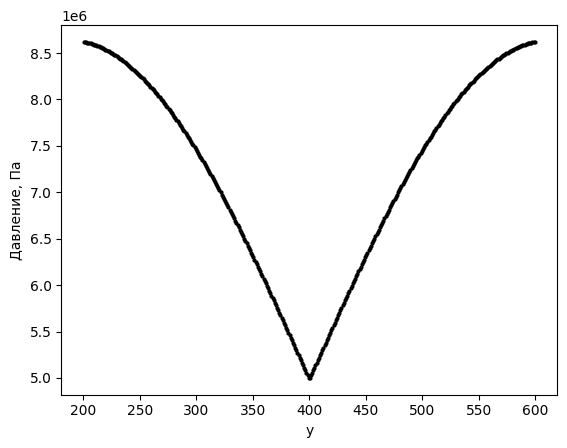

In [8]:
#График в трещине (x=5.0015)
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[0] == 5.0015 and score[1] < 600 and score[1] > 200:
        filteredCoord.append(score[1])
        filteredValue.append(score[2])

print('Координаты') 
print(filteredCoord) 
print('\n \n') 
print('Значения') 
print(filteredValue)

plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2)
plt.xlabel("y")
plt.ylabel("Давление, Па")

Координаты
[0.1, 0.3, 0.5, 0.7000000000000001, 0.8999999999999999, 1.1, 1.2999999999999998, 1.5, 1.6999999999999997, 1.8999999999999997, 2.0999999999999996, 2.3, 2.5, 2.6999999999999997, 2.9000000000000004, 3.1000000000000005, 3.3, 3.5, 3.6999999999999997, 3.9000000000000004, 4.1, 4.300000000000001, 4.5, 4.699999999999999, 4.9, 5.000500000000001, 5.0015, 5.0024999999999995, 5.0035, 5.0045, 5.0055, 5.0065, 5.106999999999999, 5.307, 5.507, 5.706999999999999, 5.906999999999999, 6.106999999999999, 6.307, 6.507, 6.706999999999999, 6.906999999999999, 7.106999999999999, 7.307, 7.507, 7.706999999999999, 7.906999999999999, 8.107, 8.306999999999999, 8.506999999999998, 8.706999999999999, 8.907, 9.107, 9.306999999999999, 9.506999999999998, 9.707, 9.907]

 

Значения
[11919544, 11905315, 11876746, 11833609, 11775548, 11702062, 11612476, 11505906, 11381203, 11236887, 11071048, 10881209, 10664147, 10415636, 10130097, 9800108, 9603073, 9473424, 9377666, 9298692, 9227953, 9161736, 9099755, 9045411, 900

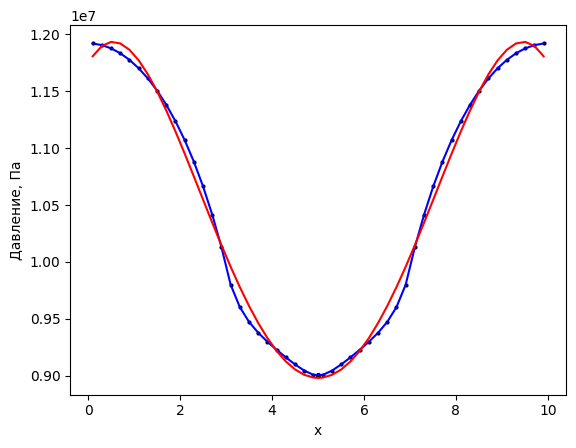

Аппроксимация: 
 p = 149094.46074110863x^3 + -822325.4503528544x^2 + 763847.4825332566x + 11738826.90472797
Максимальное отклонение: 0.01831509951051641
Метрика R^2: 0.9948175332941892


In [54]:
#Аппроксимация в срезке на y = 400.5, 500.5, 600.5, 700.5
from scipy.optimize import curve_fit
import sklearn.metrics

#График в срезке на y = 400.5, 500.5, 600.5, 700.5
filteredCoord = []
filteredValue = []
for score in ListSolution:
    if score[1] == 600.5:
        filteredCoord.append(score[0])
        filteredValue.append(score[2])

print('Координаты') 
print(filteredCoord) 
print('\n \n') 
print('Значения') 
print(filteredValue)

plt.xlabel("x")
plt.ylabel("Давление, Па")
plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2)


x = np.array(filteredCoord, dtype=np.float64)
y = np.array(filteredValue, dtype=np.float64)
 
[aa, a, b, c, d], res1 = curve_fit(lambda x1, aa, a, b, c, d: aa*x1**4+a*x1**3+b*x1**2+c*x1+d,  x,  y)
y1 = aa*x**4+ a*x**3+b*x**2+c*x+d

#[a, b, c], res1 = curve_fit(lambda x1, a, b, c: a*np.exp(b*(x1-c)**2),  x,  y)
#a=0.1
##b=0.8
#c=5
#d=0.9*10**7
#y1 = a*np.exp(b*(x-c)**2)+d

plt.plot(x, y, 'b')
plt.plot(x, y1, 'r')
plt.show()

print('Аппроксимация: \n p = ' + str(a)+'x^3 + '+ str(b)+'x^2 + '+ str(c)+'x + '+ str(d))
print('Максимальное отклонение: ' + str(max(abs((y1-y)/y))))
print('Метрика R^2: ' +str(sklearn.metrics.r2_score(y1, y)))


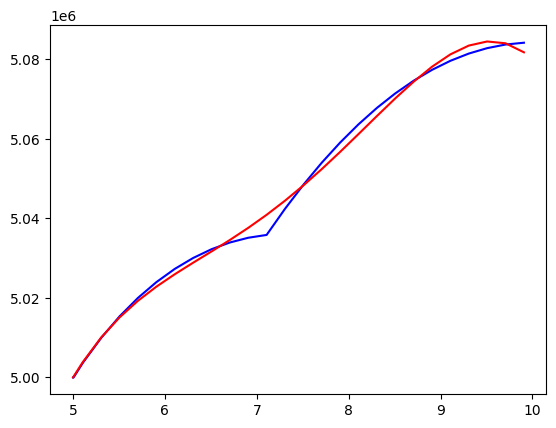

Аппроксимация: 
 p = 21988.810623005418x^3 + -237077.58956283712x^2 + 1136696.1878600447x + 2965701.776251804
Максимальное отклонение: 0.0010028042667320023
Метрика R^2: 0.9973585761964395


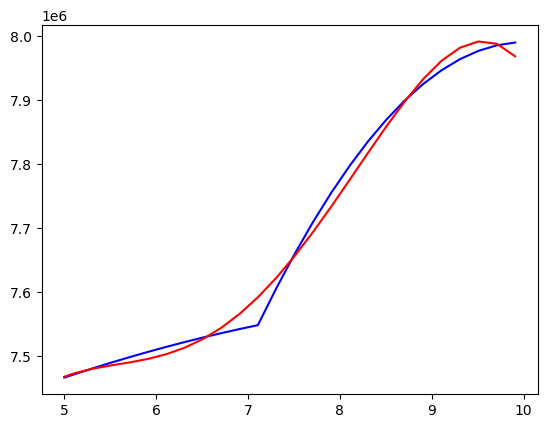

Аппроксимация: 
 p = 146774.61410771724x^3 + -1461099.7320542284x^2 + 6323458.934048148x + -2638073.9115541484
Максимальное отклонение: 0.005782611339746881
Метрика R^2: 0.99498521895402


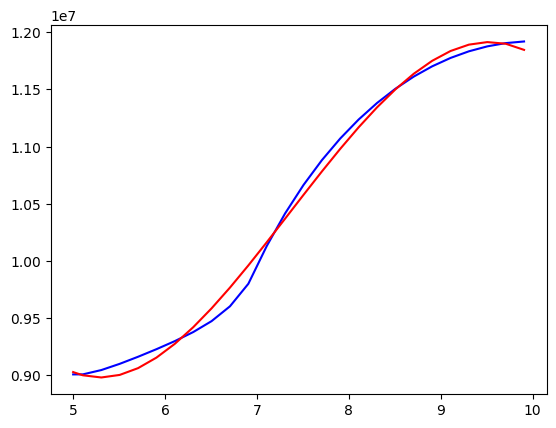

Аппроксимация: 
 p = -126116.85234158077x^3 + 2246116.3450299655x^2 + -14158644.793886764x + 38402122.99218645
Максимальное отклонение: 0.017057414146380793
Метрика R^2: 0.9964142411436435


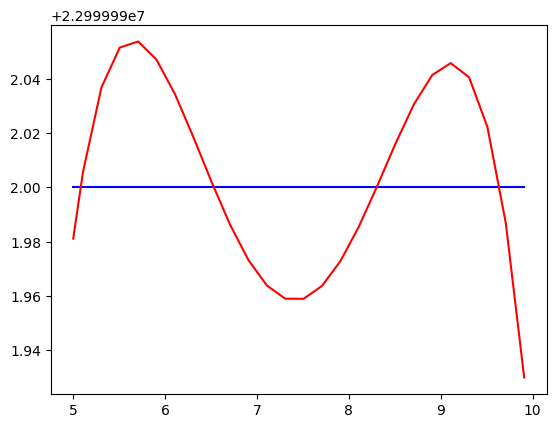

Аппроксимация: 
 p = 0.30122362522350793x^3 + -3.277434735947348x^2 + 15.539869714461792x + 22999964.934447035
Максимальное отклонение: 3.0456123048200915e-09
Метрика R^2: -4.962503741268165e-10


In [10]:
#Аппроксимация в срезке на y = 400.5, 500.5, 600.5, 700.5
from scipy.optimize import curve_fit
import sklearn.metrics

yy = [400.5, 500.5, 600.5, 700.5]

for i in yy:
    filteredCoord = []
    filteredValue = []
    for score in ListSolution:
        if score[1] == i and score[0]>FracXcoordStart:
            filteredCoord.append(score[0])
            filteredValue.append(score[2])

    x = np.array(filteredCoord, dtype=np.float64)
    y = np.array(filteredValue, dtype=np.float64)

    [aa, a, b, c, d], res1 = curve_fit(lambda x1, aa, a, b, c, d: aa*x1**4+a*x1**3+b*x1**2+c*x1+d,  x,  y)
    y1 = aa*x**4+ a*x**3+b*x**2+c*x+d

    plt.plot(x, y, 'b')
    plt.plot(x, y1, 'r')
    plt.show()

    print('Аппроксимация: \n p = ' + str(a)+'x^3 + '+ str(b)+'x^2 + '+ str(c)+'x + '+ str(d))
    print('Максимальное отклонение: ' + str(max(abs((y1-y)/y))))
    print('Метрика R^2: ' +str(sklearn.metrics.r2_score(y1, y)))



In [ ]:
#Расчет градиентов давления

ListGradSolution_X = [] #с 0 счет идет
ListGradSolution_Y = [] #с 0 счет идет
lissst = []
a = mesh
xa, ya = a.cellCenters
k = 0
for j in range(0, len(np.unique(xa))):
    for i in range(0, len(np.unique(ya))):
        ListGradSolution_X.append([xa[k], ya[k], phi.grad.value[0][k]])
        ListGradSolution_Y.append([xa[k], ya[k], phi.grad.value[1][k]])
        lissst.append([xa[k], ya[k], phi.value[k]])
        k = k + 1

filtered = []
fffiltered = []

for score in ListGradSolution_X:
    if score[0] > FracXcoordStart-3*dx_SRV and score[0] < FracXcoordFinish+dx_SRV and score[1] == 397.5:
        filtered.append(score)

        
for score in lissst:
    if score[0] > FracXcoordStart-3*dx_SRV and score[0] < FracXcoordFinish+dx_SRV and score[1] == 397.5:
        fffiltered.append(score)
        
        
print(filtered)
print('--------------')
print(fffiltered)

In [74]:
[5.000500000000001, 397.5, -12507.462686854895]


[4.9, 397.5, 5128898]
[5.000500000000001, 397.5, 5126384]
[5.0015, 397.5, 5126384]

(5126384-5128898)/(5.000500000000001-4.9)


((5133846-5138669)/(4.699999999999999-4.5)+(5128898-5133846)/(4.9-4.699999999999999))/2

array([0., 0., 0., ..., 0., 0., 0.])

3195192000.0


# Нелинейка

In [311]:
#Задание переменной решения
Pstart = 230*100000
Pwell = 50*100000
#Pwell = 0
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = Pstart) 

#Задание начального нулевого давления в "скважине"
FracXcoordStart = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV
FracXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac
FracYcoordStart = 200
FracYcoordFinish = 600
FracYcoordMedium = 400
X, Y = mesh.faceCenters
Fracfaces = (X > FracXcoordStart) & (X < FracXcoordFinish) & (Y > FracYcoordMedium-1) & (Y < FracYcoordMedium+1)

#Задание краевого нулевого давления в "скважине"
x, y = mesh.cellCenters
FracCell = (x > FracXcoordStart-1) & (x < FracXcoordFinish+1) & (y > FracYcoordMedium-2) & (y < FracYcoordMedium+2)
phi.setValue(Pwell, where=FracCell) 
phi.constrain(Pwell, Fracfaces)

#Задание коэффициента пьезопроводности и уравнения
D_SRV = 32*10**(-6)
D_Matrix = D_SRV/10
D_Frac = D_SRV*100000

D = fp.FaceVariable(mesh=mesh, value=D_SRV)
mask = ((X > FracXcoordStart) & (X < FracXcoordFinish)) & (Y > FracYcoordStart) & (Y < FracYcoordFinish)
D.setValue(D_Frac, where=mask)


MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D.setValue(D_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D.setValue(D_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D.setValue(D_Matrix, where=mask)

#Задание НЕЛИНЕЙНОГО коэффициента пьезопроводности и уравнения
D_nonlinear_SRV = 1
D_nonlinear_Matrix = 0
D_nonlinear_Frac = 0

D_nonlinear = fp.FaceVariable(mesh=mesh, value=D_nonlinear_SRV)
mask = ((X > FracXcoordStart) & (X < FracXcoordFinish)) & (Y > FracYcoordStart) & (Y < FracYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Frac, where=mask)


MatrixXcoordStart = dx_MatrixLateral*nx_MatrixLateral
MatrixXcoordFinish = dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac
MatrixYcoordStart = 200
MatrixYcoordFinish = 600
mask = (X > MatrixXcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (X < MatrixXcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y < MatrixYcoordStart)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)
mask = (Y > MatrixYcoordFinish)
D_nonlinear.setValue(D_nonlinear_Matrix, where=mask)

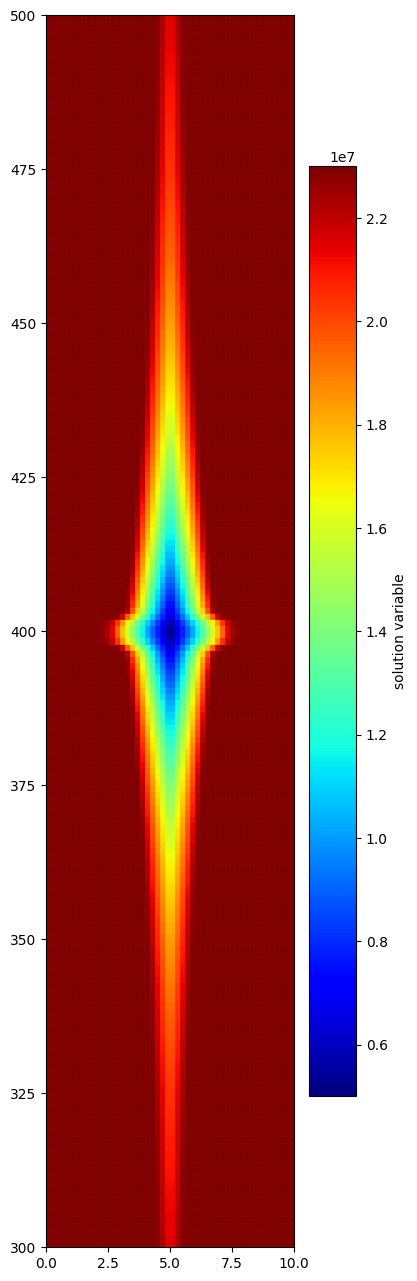

0.18052253260479925


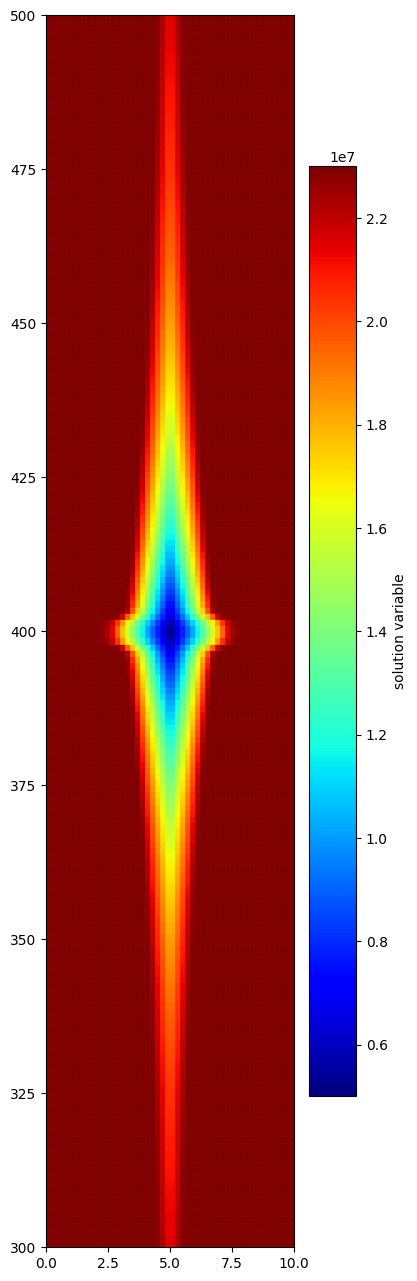

In [312]:

#Задание коэффициента пьезопроводности и уравнения
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=D*(1-D_nonlinear*phi.arithmeticFaceValue/max(phi.value)))

timeStepDuration = 3600
steps = 18
viewer = fp.Viewer(vars=phi,  ymin=300, ymax=500)
solver = fp.GeneralSolver(precon='lu')
from builtins import range
for step in range(steps):
    #aaa = D*(1-D_nonlinear*phi.arithmeticFaceValue/max(phi.value))
    eq.solve(var=phi, dt=timeStepDuration)
    #D = aaa
    viewer.plot()
    print(D.value.mean())

In [301]:
max(phi.value), min(phi.value)

(22999994, 4999999)

In [290]:
eq

(TransientTerm(coeff=1.0) + DiffusionTerm(coeff=[-((((((((((((((((((FaceVariable(value=array([3.2e-06, 3.2e-06, 3.2e-06, ..., 3.2e-06, 3.2e-06, 3.2e-06]), mesh=Mesh2D()) * (1 - ((FaceVariable(value=array([0, 0, 0, ..., 0, 0, 0]), mesh=Mesh2D()) * _ArithmeticCellToFaceVariable(value=array([22999994., 22999994., 22999994., ..., 22999994., 22999994.,
       22999994.]), mesh=Mesh2D())) / 23000000))) * (1 - ((FaceVariable(value=array([0, 0, 0, ..., 0, 0, 0]), mesh=Mesh2D()) * _ArithmeticCellToFaceVariable(value=array([22999994., 22999994., 22999994., ..., 22999994., 22999994.,
       22999994.]), mesh=Mesh2D())) / 23000000))) * (1 - ((FaceVariable(value=array([0, 0, 0, ..., 0, 0, 0]), mesh=Mesh2D()) * _ArithmeticCellToFaceVariable(value=array([22999994., 22999994., 22999994., ..., 22999994., 22999994.,
       22999994.]), mesh=Mesh2D())) / 22999999))) * (1 - ((FaceVariable(value=array([0, 0, 0, ..., 0, 0, 0]), mesh=Mesh2D()) * _ArithmeticCellToFaceVariable(value=array([22999994., 22999994.

## Построение графиков

In [ ]:
#plt.xlim(xmin=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV)
#plt.xlim(xmax=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac)
#plt.plot(r, p, 'o', color='black', markersize=1)

In [ ]:
#Отображение начального распределения давления в зоне трещины
viewer = fp.Viewer(vars=phi, 
                   xmin=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV, 
                   xmax=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac)
viewer.plot()

In [ ]:
#plt.xlim(xmin=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV)
#plt.xlim(xmax=dx_MatrixLateral*nx_MatrixLateral+dx_SRV*nx_SRV+nx_Frac*dx_Frac)
#plt.plot(r, p, 'o', color='black', markersize=1)

In [ ]:
#Отображение начального распределения давления в зоне SRV
#viewer = fp.Viewer(vars=phi, 
#                   xmin=dx_MatrixLateral*nx_MatrixLateral, 
#                   xmax=dx_MatrixLateral*nx_MatrixLateral+2*dx_SRV*nx_SRV+nx_Frac*dx_Frac)
#viewer.plot()

# Зона тестирования библиотеки ------------------------------------

# Самый простой расчет

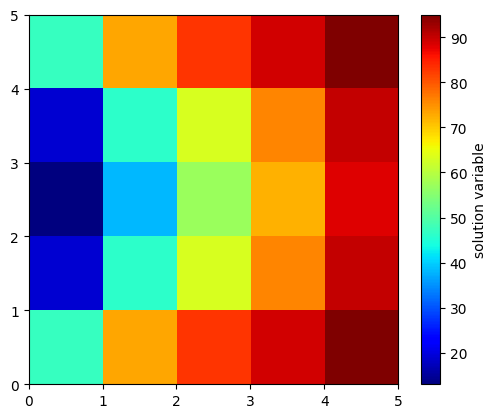

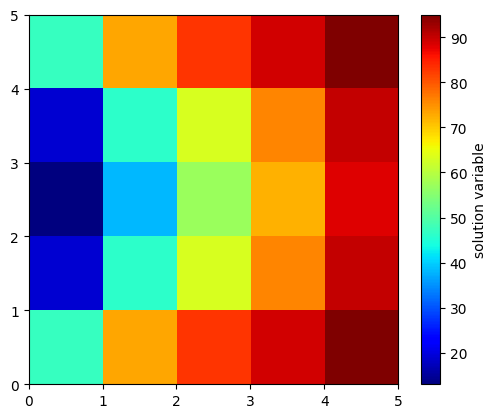

In [3]:
#Задание сетки
nx = 5
ny = 5
dx = 1.
dy = dx
L = dx * nx
mesh = fp.Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

#Задание уравнения
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 10)

#Сетка для краевых условий
X, Y = mesh.faceCenters
phi.constrain(0, mesh.facesLeft)
phi.constrain(100, mesh.facesRight)
phi.constrain(100, mesh.facesTop)
phi.constrain(100, mesh.facesDown)

#Для визуализации решения
#We create a viewer to see the results
viewer = fp.Viewer(vars=phi)
viewer.plot()
#and then create a diffusion equation. This is solved by default with an iterative conjugate gradient solver.
D = 0.1
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=D)




#Видимо .solve хранит в себе информацию о предыдущих операциях
#and solve the equation by repeatedly looping in time:
timeStepDuration = 1
steps = 100
from builtins import range
for step in range(steps):
    eq.solve(var=phi,
             dt=timeStepDuration)
    viewer.plot()
    viewer.plotMesh()

In [6]:
D1 = fp.FaceVariable(mesh=mesh, value=3)
D2 = fp.FaceVariable(mesh=mesh, value=2)
X, Y = mesh.faceCenters #Массивы координат граней ячеек

mask = (Y < 2)
D2.setValue(1, where=mask)



In [7]:
D2.value

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [8]:
Y

array([0. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 2. , 2. , 2. ,
       2. , 2. , 3. , 3. , 3. , 3. , 3. , 4. , 4. , 4. , 4. , 4. , 5. ,
       5. , 5. , 5. , 5. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5])

# Пример с неоднородной функцией проницаемости

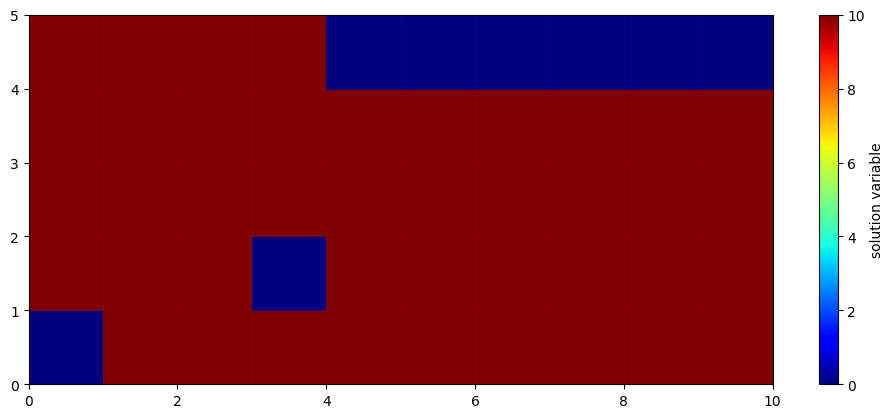

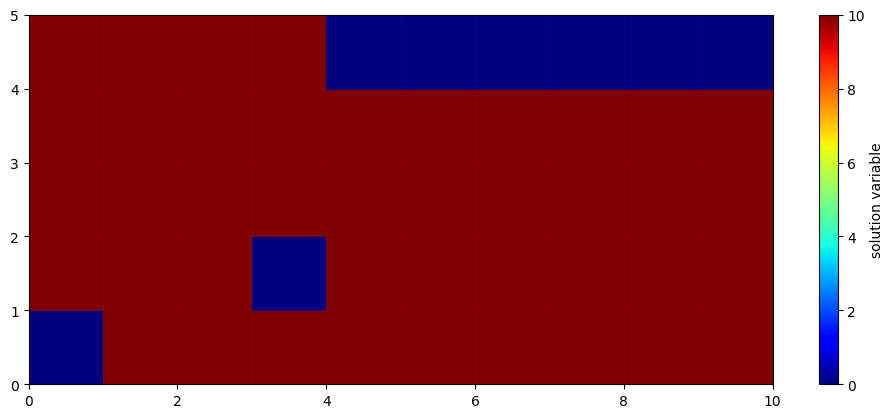

In [213]:
#Задание сетки
nx = 5
ny = 5
dx = 1.
dy = dx
L = dx * nx
mesh0 = fp.Grid2D(dx=dx, dy=dy, nx=nx, ny=ny) + ((5,),(0,))
mesh1 = fp.Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)
mesh = mesh1 + mesh0

#Задание уравнения
#We create a CellVariable and initialize it to zero:
phi = fp.CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 10.)
#and then create a diffusion equation. This is solved by default with an iterative conjugate gradient solver.
D = 1
eq = fp.TransientTerm() == fp.DiffusionTerm(coeff=D)


#to the top-left and bottom-right corners. Neumann boundary conditions are automatically applied to the top-right and bottom-left corners.
#Сетка для краевых условий
X, Y = mesh.faceCenters
#facesChoosed = (mesh.facesDown & (X > 14) & (X < 15))
phi.constrain(0, mesh.facesDown)


#Для визуализации решения
X, Y = mesh.faceCenters
#Fracfaces = (X > FracXcoordStart) & (X < FracXcoordFinish) & (Y > FracYcoordMedium-5) & (Y < FracYcoordMedium+5)

x, y = mesh.cellCenters
FracCell = (x > 0) & (x < 1) & (y > 0) & (y < 1)
phi.setValue(0, where=FracCell) 

FracCell = (x > 4) & (y > 4) 
phi.setValue(0, where=FracCell) 

FracCell = (x > 3) & (x < 4) & (y > 1) & (y < 2)
phi.setValue(0, where=FracCell) 
#phi.constrain(0, Fracfaces)

viewer = fp.Viewer(vars=phi)
viewer.plot()





In [4]:
ListSolution = [] #с 0 счет идет

a = mesh

xa, ya = a.cellCenters


k = 0
for j in range(0, len(np.unique(xa))):
    for i in range(0, len(np.unique(ya))):
        ListSolution.append([xa[k], ya[k], phi.value[k]])
        k = k + 1

        
filteredCoord = []
filteredValue = []


for score in ListSolution:
    if score[1] == 0.5:
        filteredCoord.append(score[0])
        filteredValue.append(score[2])

        
        
plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2)

In [5]:
ListSolution

[[0.5, 0.5, 0.0],
 [1.5, 0.5, 10.0],
 [2.5, 0.5, 10.0],
 [3.5, 0.5, 10.0],
 [4.5, 0.5, 10.0],
 [0.5, 1.5, 10.0],
 [1.5, 1.5, 10.0],
 [2.5, 1.5, 10.0],
 [3.5, 1.5, 0.0],
 [4.5, 1.5, 10.0],
 [0.5, 2.5, 10.0],
 [1.5, 2.5, 10.0],
 [2.5, 2.5, 10.0],
 [3.5, 2.5, 10.0],
 [4.5, 2.5, 10.0],
 [0.5, 3.5, 10.0],
 [1.5, 3.5, 10.0],
 [2.5, 3.5, 10.0],
 [3.5, 3.5, 10.0],
 [4.5, 3.5, 10.0],
 [0.5, 4.5, 10.0],
 [1.5, 4.5, 10.0],
 [2.5, 4.5, 10.0],
 [3.5, 4.5, 10.0],
 [4.5, 4.5, 0.0],
 [5.5, 0.5, 10.0],
 [6.5, 0.5, 10.0],
 [7.5, 0.5, 10.0],
 [8.5, 0.5, 10.0],
 [9.5, 0.5, 10.0],
 [5.5, 1.5, 10.0],
 [6.5, 1.5, 10.0],
 [7.5, 1.5, 10.0],
 [8.5, 1.5, 10.0],
 [9.5, 1.5, 10.0],
 [5.5, 2.5, 10.0],
 [6.5, 2.5, 10.0],
 [7.5, 2.5, 10.0],
 [8.5, 2.5, 10.0],
 [9.5, 2.5, 10.0],
 [5.5, 3.5, 10.0],
 [6.5, 3.5, 10.0],
 [7.5, 3.5, 10.0],
 [8.5, 3.5, 10.0],
 [9.5, 3.5, 10.0],
 [5.5, 4.5, 0.0],
 [6.5, 4.5, 0.0],
 [7.5, 4.5, 0.0],
 [8.5, 4.5, 0.0],
 [9.5, 4.5, 0.0]]

In [14]:
ListSolution[ListSolution[:][1]==3.5]

[0.5, 0.5, 0.0]

In [26]:
ListSolution[ListSolution[:][2]==3.5]

filteredCoord = []
filteredValue = []


for score in ListSolution:
    if score[1] == 0.5:
        filteredCoord.append(score[0])
        filteredValue.append(score[2])

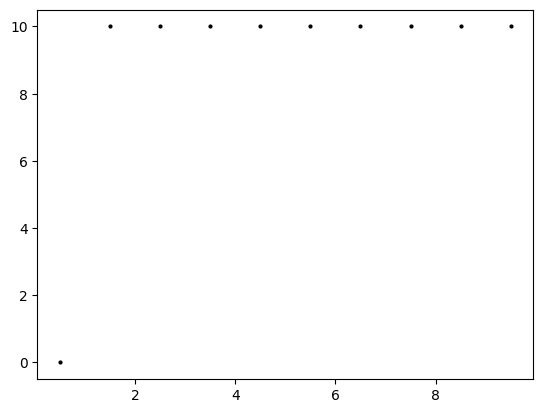

In [27]:
plt.plot(filteredCoord, filteredValue, 'o', color='black', markersize=2)

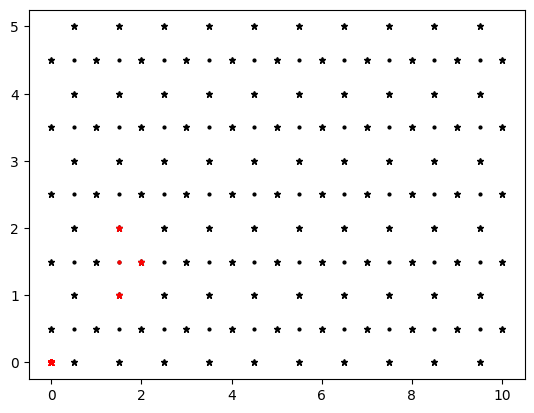

In [214]:

#plt.xlim(xmin=9.8)
#plt.xlim(xmax=10.2)
plt.plot(X, Y, '*', color='black', markersize=5)
plt.plot(x, y, 'o', color='black', markersize=2)
plt.plot(((X > 1) & (X <= 2) & (Y >= 1) & (Y <= 2))*X, ((X > 1) & (X <= 2) & (Y >= 1) & (Y <= 2))*Y, '*', color='red', markersize=5)
plt.plot(((x > 1) & (x < 2) & (y > 1) & (y < 2))*x, ((x > 1) & (x < 2) & (y > 1) & (y < 2))*y, 'o', color='red', markersize=2)


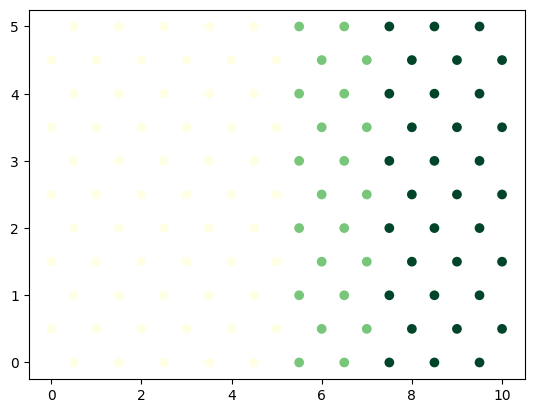

In [240]:
D = fp.FaceVariable(mesh=mesh, value=1)
mask = (X > 3)
D.setValue(1.5, where=mask)

mask = (X > 5)
D.setValue(2, where=mask)

mask = (X > 7)
D.setValue(3, where=mask)

plt.scatter(X, Y, c=D.value, cmap='YlGn')

In [219]:
len(X)

115

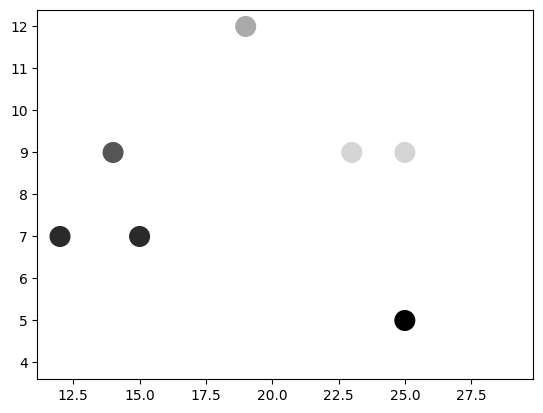

In [237]:
import pandas as pd

#create DataFrame
df = pd.DataFrame({'x': [25, 12, 15, 14, 19, 23, 25, 29],
                   'y': [5, 7, 7, 9, 12, 9, 9, 4],
                   'z': [3, 4, 4, 5, 7, 8, 8, 9]})

#view DataFrame
type(df.z)

plt.scatter(df.x, df.y, s=200, c=df.z, cmap='gray')